# Partie 1: Récuperation de 1000 images (au moins) au moins dans un nouveau repertoire pour l'entrainement du modèle

In [1]:
chemin = '/Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys'

In [2]:
import os
import random
import shutil

# Chemin vers le répertoire contenant les 10 000 images
chemin_source = chemin + '/Academic_Dataset_by_Generated_Photos/generated.photos'

# Chemin vers le nouveau répertoire où je souhaite copier les 1000 images sélectionnées
chemin_destination_parent = chemin
nom_nouveau_repertoire = 'nouveau_repertoire_code_clean'

# Nombre d'images à sélectionner
nombre_images_a_selectionner = 1000

# Créer un nouveau répertoire dans le répertoire parent
chemin_destination = os.path.join(chemin_destination_parent, nom_nouveau_repertoire)
if not os.path.exists(chemin_destination):
    os.makedirs(chemin_destination)

# Liste des chemins des fichiers dans le répertoire source
fichiers_source = os.listdir(chemin_source)

# Sélection aléatoire de 500 images
images_selectionnees = random.sample(fichiers_source, nombre_images_a_selectionner)

# Copier les images sélectionnées dans le nouveau répertoire
for image in images_selectionnees:
    chemin_image_source = os.path.join(chemin_source, image)
    chemin_image_destination = os.path.join(chemin_destination, image)
    shutil.copyfile(chemin_image_source, chemin_image_destination)

print(f"Les {nombre_images_a_selectionner} images ont été copiées avec succès dans le nouveau répertoire :", chemin_destination)


Les 1000 images ont été copiées avec succès dans le nouveau répertoire : /Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys/nouveau_repertoire_code_clean


# Utilisation de l'algorithme ITA pour classer les images suivant Fitzpatrick

In [28]:
import os
import math
import shutil
from skimage import io, color
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Définir le chemin de destination pour les images annotées
chemin_destination = chemin + '/cluster_fitzpatrick_non_filtre'

def hair_remove(image):
    # Convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Kernel for morphologyEx
    kernel = cv2.getStructuringElement(1, (17, 17))
    # Apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # Apply thresholding to blackhat
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    # Inpaint with original image and threshold image
    final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
    return final_image

def get_sample_ita_kin(path):
    ita_bnd_kin = -1
    try:
        
        rgb = io.imread(path)
        rgb = hair_remove(rgb)
        lab = color.rgb2lab(rgb)
        ita_lst = []
        ita_bnd_lst = []

        # Échantillonnage à partir de différentes parties de l'image
        L1 = lab[230:250, 115:135, 0].mean()
        b1 = lab[230:250, 115:135, 2].mean()

        L2 = lab[5:25, 115:135, 0].mean()
        b2 = lab[5:25, 115:135, 2].mean()

        L3 = lab[115:135, 5:25, 0].mean()
        b3 = lab[115:135, 5:25, 2].mean()

        L4 = lab[115:135, 230:250, 0].mean()
        b4 = lab[115:135, 230:250, 2].mean()

        L5 = lab[216:236, 216:236, 0].mean()
        b5 = lab[216:236, 216:236, 2].mean()

        L6 = lab[216:236, 20:40, 0].mean()
        b6 = lab[216:236, 20:40, 2].mean()

        L7 = lab[20:40, 20:40, 0].mean()
        b7 = lab[20:40, 20:40, 2].mean()

        L8 = lab[20:40, 216:236, 0].mean()
        b8 = lab[20:40, 216:236, 2].mean()

        L_lst = [L1, L2, L3, L4, L5, L6, L7, L8]
        b_lst = [b1, b2, b3, b4, b5, b6, b7, b8]

        # Calcul des valeurs ITA
        for L, b in zip(L_lst, b_lst):
            ita = math.atan((L - 50) / b) * (180 / math.pi)
            ita_lst.append(ita)

        # Utilisation de la valeur ITA maximale (la plus claire)
        ita_max = max(ita_lst)

        # Obtenir la classe de teinte de peau à partir de l'ITA
        if ita_max > 55:
            ita_bnd_kin = 1
        if 41 < ita_max <= 55:
            ita_bnd_kin = 2
        if 28 < ita_max <= 41:
            ita_bnd_kin = 3
        if 19 < ita_max <= 28:
            ita_bnd_kin = 4
        if 10 < ita_max <= 19:
            ita_bnd_kin = 5
        if ita_max <= 10:
            ita_bnd_kin = 6
    except Exception:
        pass

    return ita_bnd_kin

def test_skin_classification_folder(folder_path):
    try:
        # Parcourir tous les fichiers dans le dossier d'images
        for filename in tqdm(os.listdir(folder_path),desc="Traitement des images", unit="image"):
            if filename.endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(folder_path, filename)
                # Appeler la fonction de classification pour chaque image
                test_skin_classification(image_path)
    except Exception as e:
        print("Une erreur s'est produite lors du test du dossier d'images :", e)

def test_skin_classification(image_path):
    try:
        # Obtenir la classe de teinte de peau
        skin_type = get_sample_ita_kin(image_path)

        # Vérifier si la classification a réussi
        if skin_type == -1:
            print("Impossible de classer l'image.")
            return

        #print("Classification de la peau selon Fitzpatrick:", skin_type)

         # Déterminer le répertoire de destination en fonction du cluster
        num_clusters = 6
        cluster_dir = os.path.join(chemin_destination, f"Cluster_{skin_type % num_clusters}")

        # Créer le répertoire s'il n'existe pas déjà
        if not os.path.exists(cluster_dir):
            os.makedirs(cluster_dir)

        # Déplacer l'image classée dans le dossier correspondant à la classe
        destination_path = os.path.join(cluster_dir, os.path.basename(image_path))
        shutil.copy(image_path, destination_path)

    except Exception as e:
        print("Une erreur s'est produite lors du test de l'image :", e)

# Chemin du dossier contenant les images à tester
folder_path = chemin + '/nouveau_repertoire_code_clean'

# Appel de la fonction de test pour tout le dossier d'images
test_skin_classification_folder(folder_path)


Traitement des images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.47image/s]


# Vérifer si une même image ne se trouve pas dans deux ou plusieurs repertoires differents

In [28]:
import os
import shutil
from PIL import Image
from hashlib import md5

def get_image_md5(image_path):
    with Image.open(image_path) as img:
        return md5(img.tobytes()).hexdigest()

def find_duplicates(root_folder, new_folder):
    seen = {}
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(foldername, filename)
                image_hash = get_image_md5(path)
                if image_hash in seen:
                    # Copier le fichier en double dans le nouveau dossier
                    shutil.copy(path, new_folder)
                    # Supprimer le fichier en double dans son ancien emplacement
                    os.remove(seen[image_hash])
                    # Supprimer le fichier en double dans le nouveau dossier
                    os.remove(os.path.join(new_folder, filename))
                else:
                    seen[image_hash] = path

# Chemins des dossiers d'origine et du nouveau dossier
root_folder = '/Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys/cluster_maybe_fitzpatrick_5_classes_ameliorer'
new_folder = '/Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys/images_doublon'

# Vérifier si le nouveau dossier existe et est accessible en écriture
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

# Appel de la fonction pour trouver et gérer les fichiers en double
find_duplicates(root_folder, new_folder)


# Partie 2: Entrainnement et évaluation du modèle

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import shutil
import copy
from tqdm import tqdm
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys/cluster_maybe_fitzpatrick_5_classes_ameliorer'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

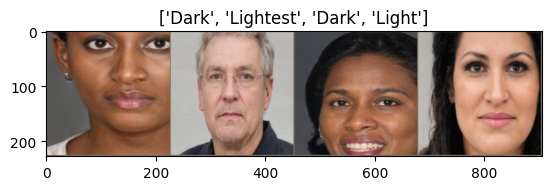

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [86]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [87]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies across epochs
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save losses and accuracies for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, 'best_model_resnet_last_version.pth')  # Save the entire model

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Plot losses and accuracies
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train')
    plt.plot(range(num_epochs), val_losses, label='Validation')
    plt.title('Loss across epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accs, label='Train')
    plt.plot(range(num_epochs), val_accs, label='Validation')
    plt.title('Accuracy across epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


In [88]:
model_ft = models.resnet101(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optimizer = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.95,nesterov=True) 

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/34
----------
train Loss: 1.3505 Acc: 0.4162
val Loss: 0.8476 Acc: 0.6695

Epoch 1/34
----------
train Loss: 0.9455 Acc: 0.6147
val Loss: 0.5889 Acc: 0.7336

Epoch 2/34
----------
train Loss: 0.8726 Acc: 0.6350
val Loss: 0.8250 Acc: 0.6880

Epoch 3/34
----------
train Loss: 0.8065 Acc: 0.6718
val Loss: 0.5503 Acc: 0.7858

Epoch 4/34
----------
train Loss: 0.7594 Acc: 0.6980
val Loss: 0.5165 Acc: 0.7858

Epoch 5/34
----------
train Loss: 0.7150 Acc: 0.7122
val Loss: 0.5290 Acc: 0.7774

Epoch 6/34
----------
train Loss: 0.6896 Acc: 0.7265
val Loss: 0.7165 Acc: 0.7201

Epoch 7/34
----------
train Loss: 0.6391 Acc: 0.7384
val Loss: 0.5368 Acc: 0.7808

Epoch 8/34
----------
train Loss: 0.6031 Acc: 0.7669
val Loss: 0.5161 Acc: 0.7841

Epoch 9/34
----------
train Loss: 0.6549 Acc: 0.7348
val Loss: 0.5068 Acc: 0.7892

Epoch 10/34
----------
train Loss: 0.6268 Acc: 0.7479
val Loss: 0.4780 Acc: 0.7976

Epoch 11/34
----------
train Loss: 0.6063 Acc: 0.7622
val Loss: 0.5034 Acc: 0.7909

Ep

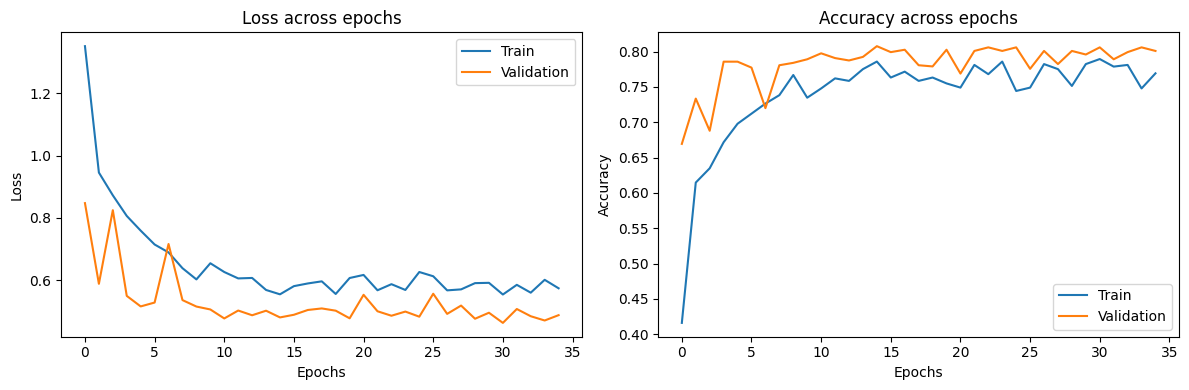

In [89]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=35)

In [6]:
# Charger le modèle PyTorch pré-entraîné
model = torch.load("best_model_resnet_last_version.pth")
model.eval()

# Vérifier le nombre de classes prédites par le modèle ResNet
num_classes = model.fc.out_features

print("Nombre de classes prédites par le modèle:", num_classes)

Nombre de classes prédites par le modèle: 5


In [ ]:
visualize_model(model_ft)

# Tester le modèle sur de nouvelles images

In [8]:
# Chemin des dossiers source et destination
source_dir = "/Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys/Academic_Dataset_by_Generated_Photos/generated.photos"
train_dir = "/Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys/cluster_maybe_fitzpatrick_5_classes copie_temporaire"
new_images_dir = "/Users/mohameddiallo/Cours_de_deepLearning/ProjetEmmanuelleClaeys/Nouveau_doss"

# Charger le modèle PyTorch pré-entraîné
model = torch.load("best_model_resnet101.pth")
model.eval()

# Transformation des images pour l'inférence
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adapter à la taille d'entrée du modèle
    transforms.ToTensor(),
])

# Fonction pour tester le modèle sur les nouvelles images
def classify_new_images(source_dir, train_dir, new_images_dir, model):
    since = time.time()
    # Liste des fichiers dans le dossier source
    source_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    # Liste des fichiers dans le dossier d'entraînement
    train_files = os.listdir(train_dir)
    
    # Création d'un nouveau dossier pour les nouvelles images
    if not os.path.exists(new_images_dir):
        os.makedirs(new_images_dir)
    
    # Comparaison des fichiers
    for file in tqdm(source_files,desc="Prédiction de nouveaux images", unit="image"):
        if file not in train_files:
            # Copie des nouvelles images dans le nouveau dossier
            shutil.copy(os.path.join(source_dir, file), os.path.join(new_images_dir, file))
            
            # Charger l'image et effectuer la prédiction
            image = Image.open(os.path.join(new_images_dir, file))
            image = transform(image).unsqueeze(0)
            output = model(image)
            _, predicted = torch.max(output, 1)
            
            # Créer un sous-dossier pour la classe prédite si nécessaire
            predicted_class_dir = os.path.join(new_images_dir, str(predicted.item()))
            if not os.path.exists(predicted_class_dir):
                os.makedirs(predicted_class_dir)
            
            # Déplacer l'image dans le sous-dossier de la classe prédite
            shutil.move(os.path.join(new_images_dir, file), os.path.join(predicted_class_dir, file))
            
    time_elapsed = time.time() - since
    print(f'Classification complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
# Appel de la fonction
classify_new_images(source_dir, train_dir, new_images_dir, model)

Prédiction de nouveaux images: 100%|███| 10000/10000 [28:50<00:00,  5.78image/s]

Classification complete in 28m 51s


# Inférence sur des images personnalisées


In [4]:
import os
import shutil
from PIL import Image
from hashlib import md5

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

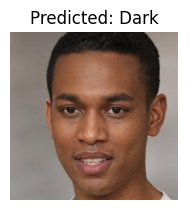

In [5]:
model_conv = torch.load("best_model_resnet101.pth")
visualize_model_predictions(
    model_conv,
    img_path='/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/classification/Lightest/generated.photos_v3_0089445.jpg'
)


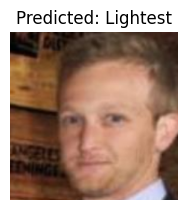

In [11]:
# Image CelebA
visualize_model_predictions( model_conv, 
img_path='/Users/mohameddiallo/Analyse-de-donnees-et-RL-inverse-pour-la-d-tection-de-biais/ProjetEmmanuelleClaeys/Predict_CelebA/Dark/159639.jpg'
)
plt.ioff()
plt.show()